In [7]:
import os
import numpy as np
import mne
import tensorflow as tf
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


In [17]:
# Define frequency bands
FREQ_BANDS = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 40)}

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return lfilter(b, a, data)

def extract_features(eeg_data, sfreq):
    features = []
    for band, (low, high) in FREQ_BANDS.items():
        filtered_signal = bandpass_filter(eeg_data, low, high, sfreq)
        features.append(np.mean(np.abs(filtered_signal)))  # Mean absolute amplitude
    return np.array(features)


In [19]:
# Load seizure file list from RECORDS-WITH-SEIZURES
def load_seizure_files(seizure_list_path):
    seizure_files = set()
    with open(seizure_list_path, 'r') as f:
        for line in f:
            # Strip whitespace and add the relative path to the set
            seizure_files.add(line.strip())
    return seizure_files

In [21]:
# Load EEG data with corrected path matching
def load_eeg_data(edf_path, seizure_files):
    X, y = [], []
    for root, _, files in os.walk(edf_path):
        for file in files:
            if file.endswith('.edf'):
                file_path = os.path.join(root, file)
                relative_path = os.path.relpath(file_path, edf_path).replace('\\', '/')
                raw = mne.io.read_raw_edf(file_path, preload=True)
                eeg_data = raw.get_data()
                sfreq = raw.info['sfreq']
                features = extract_features(eeg_data, sfreq)
                X.append(features)
                label = 1 if relative_path in seizure_files else 0
                y.append(label)
                if label == 1:
                    print(f"Seizure file detected: {relative_path}")
    return np.array(X), np.array(y)

In [23]:
# Define EEGNet model
def build_eegnet(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (1, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((1, 1)),
        tf.keras.layers.Conv2D(32, (1, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((1, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
# Paths
data_path = r"E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0"
seizure_list_path = r"E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\RECORDS-WITH-SEIZURES"


In [27]:
# Load seizure files
seizure_files = load_seizure_files(seizure_list_path)
print("Loaded seizure files:", seizure_files)

Loaded seizure files: {'', 'chb19/chb19_30.edf', 'chb04/chb04_05.edf', 'chb15/chb15_52.edf', 'chb15/chb15_22.edf', 'chb03/chb03_01.edf', 'chb16/chb16_17.edf', 'chb24/chb24_06.edf', 'chb20/chb20_13.edf', 'chb01/chb01_21.edf', 'chb20/chb20_14.edf', 'chb07/chb07_12.edf', 'chb22/chb22_25.edf', 'chb19/chb19_28.edf', 'chb24/chb24_04.edf', 'chb01/chb01_16.edf', 'chb06/chb06_09.edf', 'chb18/chb18_30.edf', 'chb13/chb13_19.edf', 'chb08/chb08_21.edf', 'chb12/chb12_10.edf', 'chb03/chb03_03.edf', 'chb24/chb24_11.edf', 'chb11/chb11_99.edf', 'chb14/chb14_17.edf', 'chb12/chb12_27.edf', 'chb24/chb24_13.edf', 'chb10/chb10_31.edf', 'chb21/chb21_22.edf', 'chb02/chb02_16+.edf', 'chb02/chb02_16.edf', 'chb10/chb10_12.edf', 'chb22/chb22_38.edf', 'chb18/chb18_35.edf', 'chb03/chb03_35.edf', 'chb15/chb15_20.edf', 'chb13/chb13_55.edf', 'chb13/chb13_62.edf', 'chb18/chb18_32.edf', 'chb21/chb21_19.edf', 'chb12/chb12_09.edf', 'chb04/chb04_28.edf', 'chb13/chb13_40.edf', 'chb21/chb21_21.edf', 'chb03/chb03_34.edf', 'chb

In [29]:
# Load data with debugging
X, y = load_eeg_data(data_path, seizure_files)
print("Unique labels in y:", np.unique(y))
print("Number of seizure samples (1):", np.sum(y == 1))
print("Number of non-seizure samples (0):", np.sum(y == 0))


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb01/chb01_03.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb01/chb01_04.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb01/chb01_15.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb01/chb01_16.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb01/chb01_18.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 681727  =      0.000 ...  2662.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb01/chb01_21.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 595199  =      0.000 ...  2324.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb01/chb01_26.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153599  =      0.000 ...   599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_41.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_43.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_46.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_16+.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb02/chb02_16+.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 245503  =      0.000 ...   958.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb02/chb02_16.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb02/chb02_19.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb03/chb03_01.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb03/chb03_02.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb03/chb03_03.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb03/chb03_04.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 923135  =      0.000 ...  3605.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb03/chb03_34.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb03/chb03_35.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb03/chb03_36.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3685887  =      0.000 ... 14397.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2441215  =      0.000 ...  9535.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb04/chb04_05.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1918975  =      0.000 ...  7495.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb04/chb04_08.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1236991  =      0.000 ...  4831.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3691519  =      0.000 ... 14419.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3685887  =      0.000 ... 14397.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3691007  =      0.000 ... 14417.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3515391  =      0.000 ... 13731.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3692799  =      0.000 ... 14424.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2735103  =      0.000 ... 10683.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3687935  =      0.000 ... 14405.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3693311  =      0.000 ... 14426.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3692287  =      0.000 ... 14422.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb04/chb04_28.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3687167  =      0.000 ... 14402.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1436927  =      0.000 ...  5612.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_41.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1490687  =      0.000 ...  5822.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_43.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 924159  =      0.000 ...  3609.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb05/chb05_06.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb05/chb05_13.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb05/chb05_16.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb05/chb05_17.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb05/chb05_22.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3693311  =      0.000 ... 14426.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb06/chb06_01.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3394815  =      0.000 ... 13260.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb06/chb06_04.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb06/chb06_09.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb06/chb06_10.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb06/chb06_13.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 775679  =      0.000 ...  3029.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2029567  =      0.000 ...  7927.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb06/chb06_18.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb06/chb06_24.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3689215  =      0.000 ... 14410.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1259519  =      0.000 ...  4919.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1192959  =      0.000 ...  4659.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb07/chb07_12.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 953855  =      0.000 ...  3725.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb07/chb07_13.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3087359  =      0.000 ... 12059.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb07/chb07_18.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3689215  =      0.000 ... 14410.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb08/chb08_02.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb08/chb08_05.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb08/chb08_11.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb08/chb08_13.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb08/chb08_21.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 927487  =      0.000 ...  3622.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2053887  =      0.000 ...  8022.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686143  =      0.000 ... 14398.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3690239  =      0.000 ... 14414.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686143  =      0.000 ... 14398.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb09/chb09_06.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb09/chb09_08.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3687679  =      0.000 ... 14404.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3689215  =      0.000 ... 14410.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3691775  =      0.000 ... 14420.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3479295  =      0.000 ... 13590.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 249343  =      0.000 ...   973.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1459199  =      0.000 ...  5699.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb09/chb09_19.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1848319  =      0.000 ...  7219.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb10/chb10_12.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1846271  =      0.000 ...  7211.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb10/chb10_20.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1847807  =      0.000 ...  7217.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb10/chb10_27.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1846527  =      0.000 ...  7212.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb10/chb10_30.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1848575  =      0.000 ...  7220.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb10/chb10_31.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb10/chb10_38.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_89.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb10/chb10_89.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921087  =      0.000 ...  3597.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_53.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_54.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_55.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_56.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_58.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_60.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_61.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_62.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_63.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_82.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb11/chb11_82.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_92.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb11/chb11_92.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_99.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 731903  =      0.000 ...  2858.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb11/chb11_99.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 923135  =      0.000 ...  3605.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_06.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_08.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 924671  =      0.000 ...  3611.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_09.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 924415  =      0.000 ...  3610.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_10.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 622335  =      0.000 ...  2430.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_11.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_23.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_27.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_28.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 927743  =      0.000 ...  3623.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_29.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_33.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_36.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 925695  =      0.000 ...  3615.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_38.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_41.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb12/chb12_42.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb13/chb13_19.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb13/chb13_21.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb13/chb13_40.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_47.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_55.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb13/chb13_55.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_56.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_58.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb13/chb13_58.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_59.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb13/chb13_59.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_60.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb13/chb13_60.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_62.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb13/chb13_62.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb14/chb14_03.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb14/chb14_04.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb14/chb14_06.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb14/chb14_11.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb14/chb14_17.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb14/chb14_18.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb14/chb14_27.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 922111  =      0.000 ...  3601.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_06.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_10.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_15.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_17.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_20.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_22.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_28.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_31.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_40.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_45.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_46.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_46.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_49.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 927999  =      0.000 ...  3624.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_49.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_50.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_51.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_52.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 923903  =      0.000 ...  3608.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_52.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_54.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_54.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_61.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_62.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb15/chb15_62.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_63.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb16/chb16_10.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb16/chb16_11.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb16/chb16_14.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb16/chb16_16.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb16/chb16_17.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb16/chb16_18.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17a_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb17/chb17a_03.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17a_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb17/chb17a_04.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17a_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17a_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17a_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_57.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_58.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_59.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_60.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_63.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 927743  =      0.000 ...  3623.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb17/chb17b_63.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_67.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_68.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_69.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 924415  =      0.000 ...  3610.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb18/chb18_29.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb18/chb18_30.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 582143  =      0.000 ...  2273.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb18/chb18_31.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb18/chb18_32.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb18/chb18_35.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb18/chb18_36.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 924671  =      0.000 ...  3611.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb19/chb19_28.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb19/chb19_29.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 853503  =      0.000 ...  3333.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb19/chb19_30.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 923135  =      0.000 ...  3605.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb20/chb20_12.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb20/chb20_13.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb20/chb20_14.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb20/chb20_15.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 888063  =      0.000 ...  3468.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb20/chb20_16.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 926207  =      0.000 ...  3617.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   741.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 758783  =      0.000 ...  2963.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_59.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_60.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_68.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 554751  =      0.000 ...  2166.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb20/chb20_68.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921343  =      0.000 ...  3598.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb21/chb21_19.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 765439  =      0.000 ...  2989.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb21/chb21_20.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb21/chb21_21.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb21/chb21_22.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 924415  =      0.000 ...  3610.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb22/chb22_20.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb22/chb22_25.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb22/chb22_38.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_51.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_54.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_77.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1916415  =      0.000 ...  7485.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb23/chb23_06.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 655359  =      0.000 ...  2559.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2647551  =      0.000 ... 10341.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb23/chb23_08.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3693055  =      0.000 ... 14425.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb23/chb23_09.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3222271  =      0.000 ... 12586.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1282303  =      0.000 ...  5008.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb24/chb24_01.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb24/chb24_03.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb24/chb24_04.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb24/chb24_06.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb24/chb24_07.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb24/chb24_09.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb24/chb24_11.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb24/chb24_13.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb24/chb24_14.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb24/chb24_15.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb24/chb24_17.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Seizure file detected: chb24/chb24_21.edf
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 273151  =      0.000 ...  1066.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\370479518.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Unique labels in y: [0 1]
Number of seizure samples (1): 141
Number of non-seizure samples (0): 545


In [31]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_test:", np.unique(y_test))


Unique labels in y_train: [0 1]
Unique labels in y_test: [0 1]


In [33]:
# Train EEGNet
X_train_cnn = X_train.reshape(-1, 1, X.shape[1], 1)
X_test_cnn = X_test.reshape(-1, 1, X.shape[1], 1)
model = build_eegnet(input_shape=(1, X.shape[1], 1))
model.fit(X_train_cnn, y_train, epochs=10, batch_size=16, validation_data=(X_test_cnn, y_test))


Epoch 1/10


C:\Users\divya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7306 - loss: 0.6538 - val_accuracy: 0.7971 - val_loss: 0.5071
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8026 - loss: 0.4986 - val_accuracy: 0.7971 - val_loss: 0.5049
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7796 - loss: 0.5287 - val_accuracy: 0.7971 - val_loss: 0.5046
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7833 - loss: 0.5263 - val_accuracy: 0.7971 - val_loss: 0.5046
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8042 - loss: 0.4979 - val_accuracy: 0.7971 - val_loss: 0.5044
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7820 - loss: 0.5262 - val_accuracy: 0.7971 - val_loss: 0.5045
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7772 - loss: 0.5325 - val_accuracy: 0.7971 - val_loss: 0.5046
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7843 - loss: 0.5254 - val_accuracy: 0.7971 - val_loss: 0.5046
Epo

In [35]:
# Extract deep features
deep_features_train = model.predict(X_train_cnn)
deep_features_test = model.predict(X_test_cnn)
print("Shape of deep_features_train:", deep_features_train.shape)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Shape of deep_features_train: (548, 2)


In [37]:
# Train SVM
svm = SVC(kernel='rbf')
svm.fit(deep_features_train, y_train)
y_pred = svm.predict(deep_features_test)


In [39]:
# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

SVM Accuracy: 0.7971014492753623
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       110
           1       0.00      0.00      0.00        28

    accuracy                           0.80       138
   macro avg       0.40      0.50      0.44       138
weighted avg       0.64      0.80      0.71       138



C:\Users\divya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\divya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\divya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


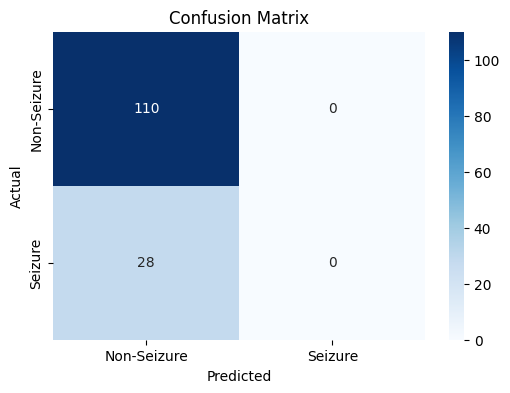

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# After SVM prediction
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Seizure', 'Seizure'], yticklabels=['Non-Seizure', 'Seizure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 681727  =      0.000 ...  2662.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 595199  =      0.000 ...  2324.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153599  =      0.000 ...   599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_41.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_43.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_46.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_16+.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 245503  =      0.000 ...   958.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 923135  =      0.000 ...  3605.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb03\chb03_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3685887  =      0.000 ... 14397.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2441215  =      0.000 ...  9535.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1918975  =      0.000 ...  7495.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1236991  =      0.000 ...  4831.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3691519  =      0.000 ... 14419.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3685887  =      0.000 ... 14397.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3691007  =      0.000 ... 14417.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3515391  =      0.000 ... 13731.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3692799  =      0.000 ... 14424.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2735103  =      0.000 ... 10683.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3687935  =      0.000 ... 14405.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3693311  =      0.000 ... 14426.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3692287  =      0.000 ... 14422.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3687167  =      0.000 ... 14402.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1436927  =      0.000 ...  5612.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_41.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1490687  =      0.000 ...  5822.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb04\chb04_43.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 924159  =      0.000 ...  3609.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb05\chb05_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3693311  =      0.000 ... 14426.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3394815  =      0.000 ... 13260.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 775679  =      0.000 ...  3029.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2029567  =      0.000 ...  7927.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb06\chb06_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3689215  =      0.000 ... 14410.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1259519  =      0.000 ...  4919.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1192959  =      0.000 ...  4659.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 953855  =      0.000 ...  3725.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3087359  =      0.000 ... 12059.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb07\chb07_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3689215  =      0.000 ... 14410.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb08\chb08_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 927487  =      0.000 ...  3622.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2053887  =      0.000 ...  8022.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686143  =      0.000 ... 14398.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3690239  =      0.000 ... 14414.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686143  =      0.000 ... 14398.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3687679  =      0.000 ... 14404.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3689215  =      0.000 ... 14410.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3691775  =      0.000 ... 14420.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3479295  =      0.000 ... 13590.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 249343  =      0.000 ...   973.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb09\chb09_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1459199  =      0.000 ...  5699.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1848319  =      0.000 ...  7219.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1846271  =      0.000 ...  7211.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1847807  =      0.000 ...  7217.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1846527  =      0.000 ...  7212.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1848575  =      0.000 ...  7220.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb10\chb10_89.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...  7199.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921087  =      0.000 ...  3597.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_53.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_54.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_55.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_56.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_58.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_60.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_61.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_62.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_63.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_82.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_92.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb11\chb11_99.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 731903  =      0.000 ...  2858.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 923135  =      0.000 ...  3605.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 924671  =      0.000 ...  3611.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 924415  =      0.000 ...  3610.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 622335  =      0.000 ...  2430.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 927743  =      0.000 ...  3623.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 925695  =      0.000 ...  3615.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_41.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb12\chb12_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_47.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_55.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_56.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_58.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_59.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_60.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb13\chb13_62.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb14\chb14_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 922111  =      0.000 ...  3601.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_45.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_46.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_49.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 927999  =      0.000 ...  3624.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_50.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_51.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_52.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 923903  =      0.000 ...  3608.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_54.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_61.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_62.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb15\chb15_63.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb16\chb16_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17a_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17a_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17a_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17a_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17a_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_57.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_58.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_59.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_60.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_63.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 927743  =      0.000 ...  3623.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_67.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_68.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17b_69.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb17\chb17c_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 924415  =      0.000 ...  3610.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 582143  =      0.000 ...  2273.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb18\chb18_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 924671  =      0.000 ...  3611.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb19\chb19_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 853503  =      0.000 ...  3333.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 923135  =      0.000 ...  3605.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 888063  =      0.000 ...  3468.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 926207  =      0.000 ...  3617.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   741.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 758783  =      0.000 ...  2963.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_59.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_60.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb20\chb20_68.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 554751  =      0.000 ...  2166.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921343  =      0.000 ...  3598.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 765439  =      0.000 ...  2989.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb21\chb21_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 924415  =      0.000 ...  3610.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_51.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_54.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb22\chb22_77.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1916415  =      0.000 ...  7485.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 655359  =      0.000 ...  2559.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2647551  =      0.000 ... 10341.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3693055  =      0.000 ... 14425.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3222271  =      0.000 ... 12586.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686399  =      0.000 ... 14399.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb23\chb23_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1282303  =      0.000 ...  5008.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\MTech Projects\Suseela\Dataset\Extracted\chb-mit-scalp-eeg-database-1.0.0\chb24\chb24_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 273151  =      0.000 ...  1066.996 secs...


C:\Users\divya\AppData\Local\Temp\ipykernel_73492\2728897552.py:40: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Unique labels in y: [0 1]
Number of seizure samples (1): 141
Number of non-seizure samples (0): 545
Epoch 1/10


C:\Users\divya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4639 - loss: 1.4568 - val_accuracy: 0.2029 - val_loss: 0.9734
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4911 - loss: 1.3063 - val_accuracy: 0.2029 - val_loss: 1.0421
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4654 - loss: 1.2963 - val_accuracy: 0.2029 - val_loss: 1.0900
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5124 - loss: 1.2442 - val_accuracy: 0.2029 - val_loss: 1.1263
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4981 - loss: 1.2552 - val_accuracy: 0.2029 - val_loss: 1.0991
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4892 - loss: 1.2571 - val_accuracy: 0.2029 - val_loss: 1.0828
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5261 - loss: 1.2373 - val_accuracy: 0.2029 - val_loss: 1.2011
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4861 - loss: 1.2619 - val_accuracy: 0.2029 - val_loss: 1.2533
Epo

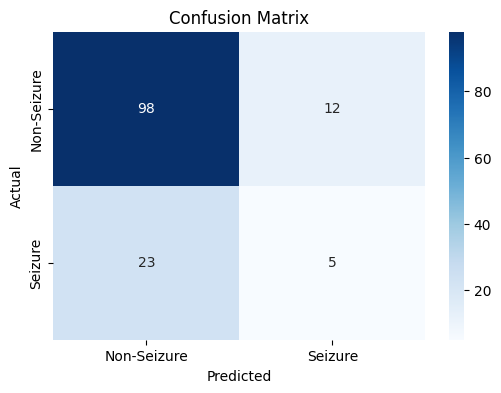

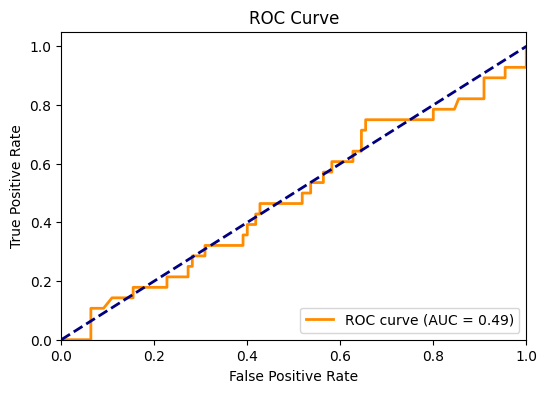

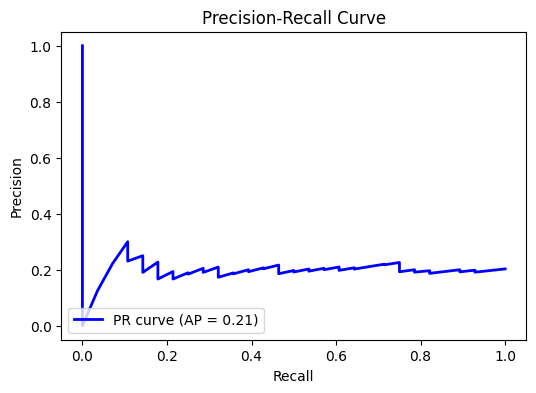

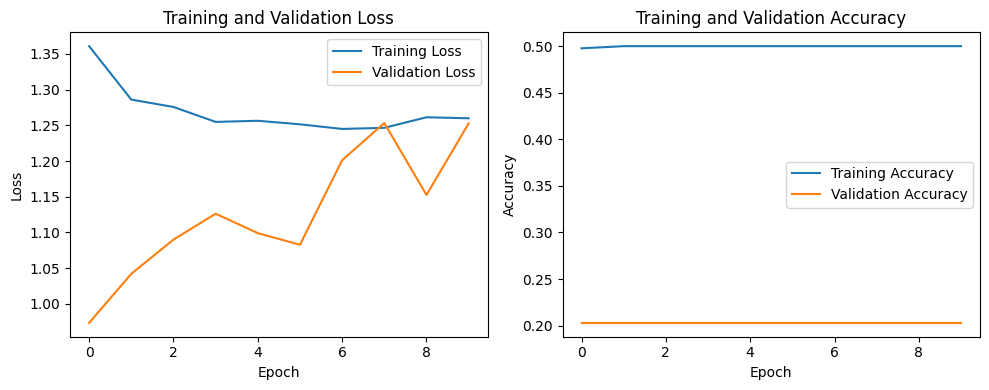

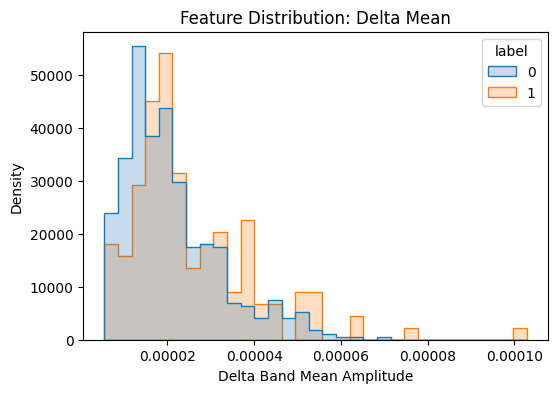